# Movie Reccomendation System

In [497]:
#!pip install surprise

In [498]:
# from surprise import SVD, accuracy
# from surprise import Dataset, Reader
# from surprise.model_selection import cross_validate
# from surprise.model_selection.split import train_test_split

In [2]:
from random import gauss as gs, uniform as uni, seed
import numpy as np
import pandas as pd
import statistics as stats
from sklearn.naive_bayes import LabelBinarizer
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [31]:
movies = pd.read_csv('ml-latest/movies.csv')
#links = pd.read_csv('Data/links.csv')
ratings = pd.read_csv('ml-latest/ratings.csv')
#tags = pd.read_csv('Data/tags.csv')

# Data Cleaning

In [32]:
movies[450:455]

,movieId,title,genres
450,455,Free Willy (1993),Adventure|Children|Drama
451,456,Fresh (1994),Crime|Drama|Thriller
452,457,"Fugitive, The (1993)",Thriller
453,458,Geronimo: An American Legend (1993),Drama|Western
454,459,"Getaway, The (1994)",Action|Adventure|Crime|Drama|Romance|Thriller


In [33]:
#Get the year from title
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['title'] = movies.title.str[:-7]

In [34]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [35]:
def get_movie_name(movie_id):
    try:
        return movies.loc[movie_id, 'title']
    except KeyError:
        return "Movie not found"
    
def get_movie_genres(movie_id):
    try:
        return movies.loc[movie_id, 'genres']
    except KeyError:
        return "Movie not found"
    
def get_movie_year(movie_id):
    try:
        return movies.loc[movie_id, 'year']
    except KeyError:
        return "Movie not found"
    
def get_movie_rating(movie_id):
    try:
        rating = movies.loc[movie_id, 'avg_rating']
        return f'{round(rating,2)}'
    except KeyError:
        return "Movie rating not found"
    
def get_movie_num_reviews(movie_id):
    try:
        num = movies.loc[movie_id, 'num_reviews']
        return f'{int(num)} users'
    except KeyError:
        return " "    

def movie_pretty_string(movie_id):
    try:
        string = f'{get_movie_name(movie_id)}, {get_movie_year(movie_id)}   | {get_movie_rating(movie_id)} by {get_movie_num_reviews(movie_id)} users |  {get_movie_genres(movie_id)}'
        return string
    except KeyError:
        return "Movie not found"

m = movies.loc[1, 'title']
m = movie_pretty_string(3)
m

'Waiting to Exhale, 1995   | Movie rating not found by   users |  Comedy|Drama|Romance'

## Using 'Ratings' to get an average rating per movie

In [36]:
ratings_movie_mean = ratings.groupby('movieId').mean()
mean_rating = ratings.groupby('movieId').mean()['rating']
movies['avg_rating'] = mean_rating
movies['num_reviews'] = ratings.groupby('movieId').count()['rating']


movies.head()
mean_rating

movieId
1         3.893508
2         3.278179
3         3.171271
4         2.868395
5         3.076957
            ...   
288967    3.500000
288971    0.500000
288975    4.000000
288977    3.000000
288983    3.000000
Name: rating, Length: 83239, dtype: float64

In [37]:
#remove movies with no reviews. 
#drop na was not working, so use an impossible value to drop
movies['avg_rating'] = movies['avg_rating'].fillna(-1)

#save to other dataframe in case needed later
unreviewed_movies = movies.loc[movies['avg_rating'] == -1]

movies = movies.loc[movies['avg_rating'] != -1]
movies

,movieId,title,genres,year,avg_rating,num_reviews
1,2,Jumanji,Adventure|Children|Fantasy,1995,3.893508,76813.0
2,3,Grumpier Old Men,Comedy|Romance,1995,3.278179,30209.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,3.171271,15820.0
4,5,Father of the Bride Part II,Comedy,1995,2.868395,3028.0
5,6,Heat,Action|Crime|Thriller,1995,3.076957,15801.0
...,...,...,...,...,...,...
86508,288901,In Your Dreams,Comedy|Drama|Romance,2023,3.000000,6.0
86510,288905,Last Night of Amore,Crime|Thriller,2023,3.125000,4.0
86518,288935,Kosovolove,(no genres listed),2000,3.173913,23.0
86521,288941,Mixed Baggage,Comedy|Drama|Romance,2023,3.000000,6.0


In [38]:
movies.describe()

,movieId,avg_rating,num_reviews
count,16351.000000,16351.000000,16351.000000
mean,101738.816953,3.185190,1796.134243
std,104284.869142,0.500239,5979.522728
min,2.000000,0.500000,1.000000
25%,4294.500000,2.884102,32.000000
50%,26574.000000,3.250000,140.000000
75%,197540.000000,3.550164,816.500000
max,288983.000000,5.000000,122296.000000


In [39]:
stats.mode(movies['num_reviews'])

7.0

## One-hot Encoding the Genres

In [40]:
def unpack_genres(string):
    s = string.split('|')
    return s

test = pd.DataFrame()
test['genres'] = movies['genres'].map(unpack_genres)
movies['genres'] = movies['genres'].map(unpack_genres)

In [41]:
unique_genres = [ ]
for row in test['genres']:
    for genre in row:
        if genre not in unique_genres:
            unique_genres.append(genre)

unique_genres

['Adventure',
 'Children',
 'Fantasy',
 'Comedy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Animation',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir',
 '(no genres listed)']

In [44]:
movie_genre_matrix = pd.DataFrame()
movie_genre_matrix['movieId'] = movies['movieId']

for genre in unique_genres:
    movie_genre_matrix[genre] = movies['genres'].apply(lambda x: 1 if genre in x else 0)


# summary_df = pd.Dataframe()

for col in movie_genre_matrix.columns:
    summ = movie_genre_matrix[col].sum()
    print(f'{col} has {summ} movies')
    # summary_df['Genre'] = col
    # summary_df['sum'] = summ
movie_genre_matrix.info()

movieId has 1663531396 movies
Adventure has 1228 movies
Children has 876 movies
Fantasy has 734 movies
Comedy has 4897 movies
Romance has 2239 movies
Drama has 6865 movies
Action has 1920 movies
Crime has 1483 movies
Thriller has 2327 movies
Horror has 1597 movies
Animation has 706 movies
Mystery has 803 movies
Sci-Fi has 1032 movies
IMAX has 29 movies
Documentary has 1298 movies
War has 503 movies
Musical has 350 movies
Western has 356 movies
Film-Noir has 100 movies
(no genres listed) has 833 movies
<class 'pandas.core.frame.DataFrame'>
Index: 16351 entries, 1 to 86536
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   movieId             16351 non-null  int64
 1   Adventure           16351 non-null  int64
 2   Children            16351 non-null  int64
 3   Fantasy             16351 non-null  int64
 4   Comedy              16351 non-null  int64
 5   Romance             16351 non-null  int64
 6   Drama   

In [45]:
#Genres are preserved as a list in the movies df
movies.head()


,movieId,title,genres,year,avg_rating,num_reviews
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,3.893508,76813.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,3.278179,30209.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,3.171271,15820.0
4,5,Father of the Bride Part II,[Comedy],1995,2.868395,3028.0
5,6,Heat,"[Action, Crime, Thriller]",1995,3.076957,15801.0


# Data Exploration

In [46]:
m_year = movies.sort_values(by=['year'])
fig = px.scatter(m_year, x='year', y='avg_rating', hover_data=['title', 'num_reviews'], color='num_reviews')
fig.show()

Most movies have a low number of reviews, especially the highest and lowest scores. 

In [47]:
print(movies['num_reviews'].describe())
stats.median(movies['avg_rating'])

count     16351.000000
mean       1796.134243
std        5979.522728
min           1.000000
25%          32.000000
50%         140.000000
75%         816.500000
max      122296.000000
Name: num_reviews, dtype: float64


3.25

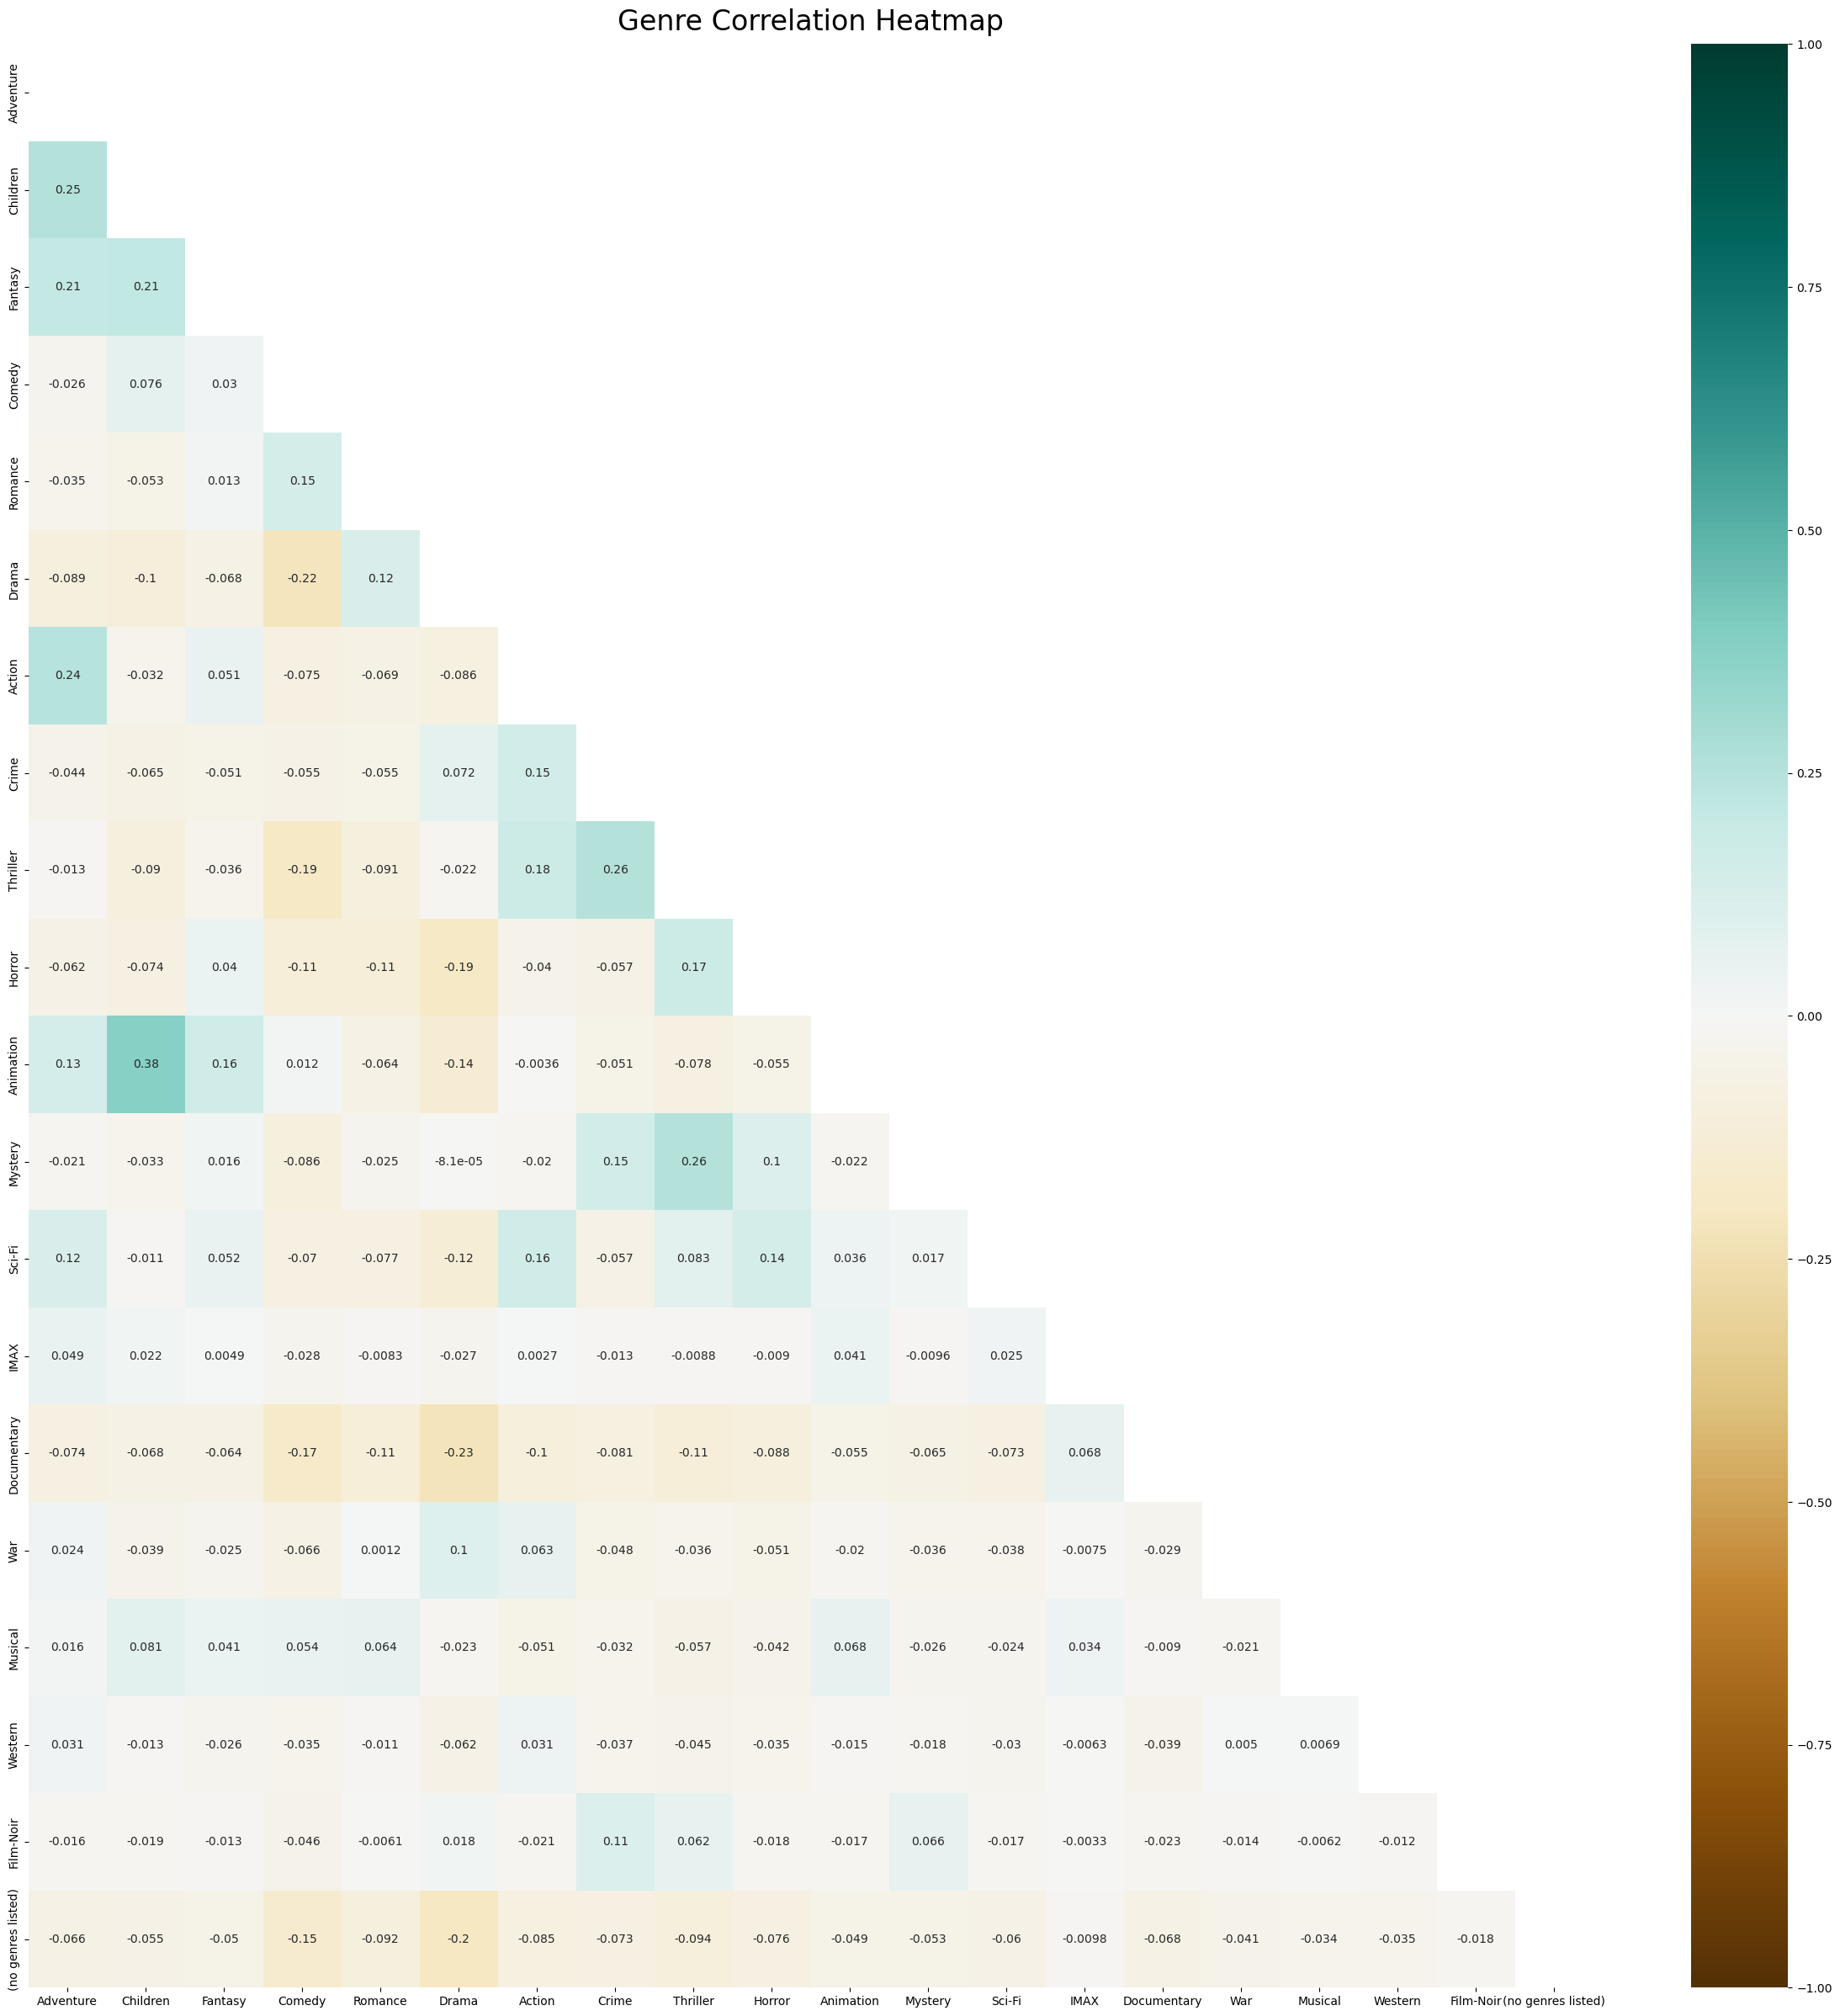

In [48]:
df_matrix = movie_genre_matrix.drop(columns='movieId')

corr_matrix = df_matrix.corr()

plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Genre Correlation Heatmap', fontdict={'fontsize':24}, pad=12);

## Examining movies

It was most common (median) for movies to have 4 reviews. However, the mean number of reviews was around 14. I've chosen to filter for movies with more than 14 reviews. 

This is to help remove outliers (where small groups of person had rank a movie incredible high or low due to their personal tastes).

In [53]:
#The average movie has 14 reviews
rated_movies = movies.loc[movies['num_reviews'] >= 1796]

# Find Highest rated movies:
top_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=False)

# Lowest rated movies
lowest_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=True)

print("Top 10 highest rated movies")
print(top_10['title'][:10])
print()
print("Bottom 10 lowest rated movies")
print(lowest_10[:10])


Top 10 highest rated movies
318                  Swimming with Sharks
858                            Girls Town
1221    Treasure of the Sierra Madre, The
50                         Guardian Angel
1203                     Harold and Maude
2019                            Jerk, The
527                            Serial Mom
2959                                Dogma
5618                         Endless Love
904                       Golden Earrings
Name: title, dtype: object

Bottom 10 lowest rated movies
       movieId                                        title  \
3593      3693                           Toxic Avenger, The   
6482      6604  Hawks and Sparrows (Uccellacci e Uccellini)   
8666     26220  Violent City (Family, The) (Città violenta)   
1760      1848                               Borrowers, The   
3268      3361                                  Bull Durham   
810        828                 Adventures of Pinocchio, The   
78893   263705                                   The 

In [19]:
top_year = top_10.sort_values(by=['year'])
fig = px.scatter(top_year, x='year', y='avg_rating', hover_data=['title', 'num_reviews'], color='num_reviews')
fig.show()

# Cosine Similarity

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [21]:
def top_k_items(item_id, top_k, corr_mat, map_name):

    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:]
    top_items = [map_name[e] for e in top_items]

    return top_items


# compute similarity matix
corr_mat = cosine_similarity(movie_genre_matrix)

#toy story
test_movie = 100

# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(movie_genre_matrix.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind[test_movie],
                            top_k = 10,
                            corr_mat = corr_mat,
                            map_name = ind2name)

# display result
print(f'The top-k similar movie to: {get_movie_name(test_movie)}')
for movie in similar_items:
    print(f'Movie: {get_movie_name(movie)}')
    print(f'Correlation: {corr_mat[movie]}')
    print(movies.loc[movies['movieId'] == movie]['genres'])

The top-k similar movie to: Before and After
Movie: Nadja
Correlation: [0.75592085 0.90592021 0.9187152  ... 0.99998928 0.99998928 0.99998932]
128    [Adventure, Drama, War]
Name: genres, dtype: object
Movie: Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A)
Correlation: [0.75592682 0.90453149 0.91766036 ... 0.99999719 0.99999719 0.99999719]
282    [Comedy, Drama]
Name: genres, dtype: object
Movie: Kids
Correlation: [0.7559113  0.90596947 0.91985805 ... 0.99997673 0.9999767  0.99997666]
Series([], Name: genres, dtype: object)
Movie: Secret of Roan Inish, The
Correlation: [0.75591702 0.90621362 0.9195817  ... 0.99998426 0.99998424 0.99998424]
235    [Drama, Horror, Sci-Fi]
Name: genres, dtype: object
Movie: Awfully Big Adventure, An
Correlation: [0.75591674 0.90623254 0.9189516  ... 0.99998386 0.99998386 0.9999839 ]
105    [Drama]
Name: genres, dtype: object
Movie: Client, The
Correlation: [0.75685758 0.90452852 0.91765734 ... 0.9999939  0.9999939  0.999993

# Ratings

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [23]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [24]:
ratings = ratings.drop(columns='timestamp')

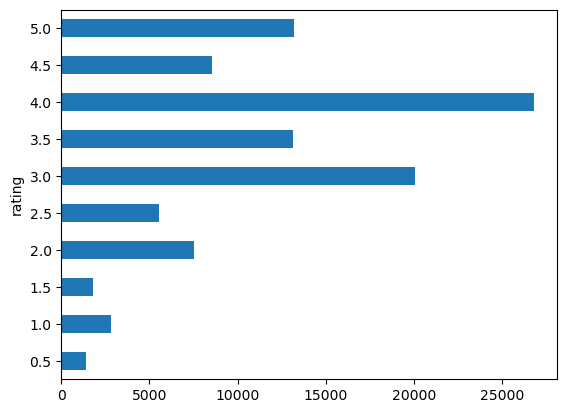

In [25]:
ax = ratings['rating'].value_counts().sort_index().plot(kind='barh')

## Exploring 'Super Users' ie. people who rate a lot of movies.

In [78]:
ratings['num_reviews'] = ratings['userId'].value_counts()
ratings['userId'].value_counts()

userId
189614    33332
48766      9554
207216     9178
175998     9016
76618      8919
          ...  
118297        1
228609        1
159558        1
12701         1
104595        1
Name: count, Length: 330975, dtype: int64

In [28]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,num_reviews
13633,89,3604,0.5,NaN


In [709]:
highest_rated

np.int64(31945)

# Grabbing a Random User

In [85]:
seed = 42
a = ratings.loc[ratings['userId']== 123]
favs = a['movieId'].map(get_movie_name)
a ['movie'] = favs
a.sort_values(by='rating', ascending=False)

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_36786/106501130.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,userId,movieId,rating,timestamp,num_reviews,movie
11011,123,40815,5.0,1135979826,120.0,Grand Hotel
10657,123,1247,5.0,1135977935,42.0,Raise the Red Lantern (Da hong deng long gao g...
10700,123,1617,5.0,1089405089,122.0,Chairman of the Board
10701,123,1641,5.0,1089221979,12.0,Guy
10702,123,1673,5.0,1135977909,16.0,Caught Up
...,...,...,...,...,...,...
10687,123,1375,2.0,1066770196,15.0,"Whole Wide World, The"
10768,123,2411,1.5,1125615098,423.0,Office Space
10917,123,5378,1.0,1066770911,127.0,Tadpole
10778,123,2628,1.0,1066770912,15.0,Inspector Gadget


# our super star

In [82]:
seed = 42
a = ratings.loc[ratings['userId']== 189614]
favs = a['movieId'].map(get_movie_name)
a ['movie'] = favs
a.sort_values(by='rating')

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_36786/2994471550.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,userId,movieId,rating,timestamp,num_reviews,movie
19367218,189614,167106,0.5,1490178569,NaN,Movie not found
19368695,189614,174049,0.5,1498209486,NaN,Movie not found
19358189,189614,113416,0.5,1455577728,NaN,Movie not found
19355056,189614,89281,0.5,1450164183,NaN,Movie not found
19360747,189614,131504,0.5,1453243540,NaN,Movie not found
...,...,...,...,...,...,...
19360502,189614,129958,5.0,1465648880,NaN,Movie not found
19353016,189614,72852,5.0,1455274833,NaN,Good After Bad
19362202,189614,140152,5.0,1455251737,NaN,Movie not found
19348801,189614,25918,5.0,1455488788,NaN,Outlaw Justice


# Creating a Sparse Matrix & Using KNN

In [710]:
N = len(ratings['userId'].unique())
M = len(ratings['movieId'].unique())

# Map Ids to indices
user_mapper = dict(zip(np.unique(ratings["userId"]), list(range(N))))
movie_mapper = dict(zip(np.unique(ratings["movieId"]), list(range(M))))
    
# And the reverse - Map indices to IDs
user_inv_mapper = dict(zip(list(range(N)), np.unique(ratings["userId"])))
movie_inv_mapper = dict(zip(list(range(M)), np.unique(ratings["movieId"])))
    
user_index = [user_mapper[i] for i in ratings['userId']]
movie_index = [movie_mapper[i] for i in ratings['movieId']]

mr_matrix = csr_matrix((ratings["rating"], (movie_index, user_index)), shape=(M, N))

In [711]:
def find_similar_movies_knn(movie_id, sparse_matrix, k, metric='cosine', show_distance=False):
    """
    Find similar movies using KNN
    """

    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = sparse_matrix[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(sparse_matrix)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 3

similar_ids = find_similar_movies_knn(movie_id, mr_matrix, k=10)
movie_title = movie_titles[movie_id]

print(f"Other people who watched {movie_title} also enjoyed:")
for i in similar_ids:
    print(f'    - {get_movie_name(i)}')
    print(f'        - {get_movie_genres(i)}')



Other people who watched Grumpier Old Men also enjoyed:
    - Heat
        - ['Action', 'Crime', 'Thriller']
    - Vermont Is For Lovers
        - ['Comedy', 'Documentary', 'Romance']
    - Don't Be a Menace to South Central While Drinking Your Juice in the Hood
        - ['Comedy', 'Crime']
    - She's the One
        - ['Comedy', 'Romance']
    - Mr. Wonderful
        - ['Comedy', 'Romance']
    - Tom and Huck
        - ['Adventure', 'Children']
    - Gospa
        - ['Drama']
    - Hate (Haine, La)
        - ['Crime', 'Drama']
    - Phenomenon
        - ['Drama', 'Romance']
    - Very Natural Thing, A
        - ['Drama']


# Surprise!

In [526]:
from collections import defaultdict

In [527]:
# preprocessing the data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# initial model
algo = SVD(random_state = 42)
algo.fit(train)
predictions = algo.test(test)

# evaluate the rmse result of the prediction and ground thuth
accuracy.rmse(predictions)

NameError: name 'Reader' is not defined

In [1]:
def get_top_picks(predictions, num_recs = 10):
    """Return the top-N recommendation for each user from a set of predictions.

    predictions(list of Prediction objects): The list of predictions, as returned by suprise's algorithm.
    num_recs (int): The number of recommendation to output for each user. Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size num_recs.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:num_recs]

    return top_n

top_n = get_top_picks(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

NameError: name 'predictions' is not defined

In [86]:
movie_pretty_string(293)

"Panther, 1995   | 4.1 by 43539 users users |  ['Drama']"

In [87]:
movie_pretty_string(260)

"Ladybird Ladybird, 1994   | 4.09 by 97202 users users |  ['Drama']"

In [88]:
movie_pretty_string(1196)

"Once Upon a Time in America, 1984   | 4.12 by 80200 users users |  ['Crime', 'Drama']"